# Keras 101: Designing your Neural Network - How Many Hidden Layers?

Hopefully you will have followed our walkthrough on the affect of adding more neurons to a single hidden layers.

We stared with the simpliest componant of a neural network the neuron and saw how this describes a linear classifier. We then saw that for each neuron added to a single hidden layer a new linear representation of your input data can be used in the final output of the neural network. As such with an arbitary number of neurons any decision boundary that can be described with a single mapping of one space onto another.

The next question we look to answer is that of "How many hidden layers does my network need?".

At this point a question you might have is if a single hidden layer with an arbitary number of neurons can ..... an arbitary number of neurons in a single hidden layer can represent any nonlinear decision boundary  that can be described by a single mapping of one space onto another is there a need for a second layer? In reality it is rare to find a problem that requires more than a single hidden layer, if you find yourself in a situation where you feel like you require more you should carefully consider if there is anything else you haven't addressed in relation to how you are training your network or the framing of the problem you are trying to solve. 

Having said that adding a second hidden layer can be benifitial for certain situations, here we look to outline the affect of introducing a second hidden layer to your neural network and some situations where this can be benifitial.

So after that disclaimer onto adding more hidden layers.

We then saw how adding multiple nurons to a single hidden layer results in a decision boundary that is the sum of multiple linear boundaries passed through a output neuron for normalisation. Thus allowing for a represention of any single function that maps one finite space onto another. 

Very rare to need more than one hidden layer.

Generate hilly vally data for 2 layer network comparison.

1 - sometimes it requires a large number of neurons in a single layer to produced adequate loss. 2 - a second layer can reduce the total number of parameters in the network.

We will now explore the effect of adding more hidden layers to our neural network.

As just described a single hidden layer feeding into a neuron is able to represent any single function that maps one finite space onto another resulting in a nonlinear representation of the dataset. Thus adding a second hidden layer results in an array of nonlinear represnetations of the data, that can the be combined into a highly nonlinear model.

More formally the network can represent an arbitrary decision boundary to arbitrary accuracy and can approximate any smooth mapping to any accuracy.

We are now going to explore some examples where a second hidden layer can be benifical.

In order to begin we need to import the necessary packages as well as a couple of functions we will be using to generate some testing data and plot.

In [27]:
import keras
import numpy as np
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gkern2(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    guass = fi.gaussian_filter(inp, nsig)/kernlen
    max1 = np.amax(guass)
    gauss = guass/max1
    return gauss

def generateGaussianHill(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = gkern2(spacer,sig)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacer)
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def generateGaussianHillValley(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = np.append(gkern2(spacer,9),-1*gkern2(spacer,9),axis=0)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/(2*spacer))
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def plotGaussian(labels,xmin,xmax,ymin,ymax,spacerx,spacery,label):
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacerx)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacery)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    gaus = labels.reshape(X.shape)
    ax.plot_surface(X, Y, gaus)
    fig.suptitle(label)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
def lossPlot(loss,label):
    
    epoch = np.arange(0, len(loss))
    plt.plot(epoch,loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


For this example we will be attempting to produce a neural netowrk that aims to generate a 2d gaussian hill. A plot of which can be found by running the code below.

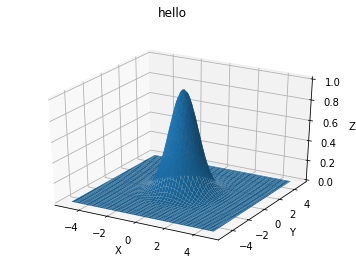

In [28]:
features, labels = generateGaussianHill(-5.0,5.0,-5.0,5.0,100,9)
plotGaussian(labels,-5.0,5.0,-5.0,5.0,100,100,"hello")

Inorder to for 

In [29]:
layers = []
layers.append(keras.layers.Dense(5, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model1 = keras.Sequential(layers)
print(model1.summary())

layers = []
layers.append(keras.layers.Dense(15, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model2 = keras.Sequential(layers)
print(model2.summary())

layers = []
layers.append(keras.layers.Dense(45, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model3 = keras.Sequential(layers)
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 15)                45        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 16        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (t

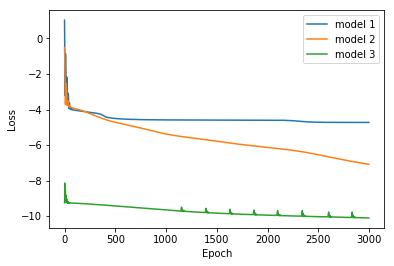

In [30]:
model1.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history1 = model1.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model2.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history2 = model2.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history3 = model3.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history3 = model3.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)

lossPlot(np.log(history1.history['loss']),"model 1")
lossPlot(np.log(history2.history['loss']),"model 2")
lossPlot(np.log(history3.history['loss']),"model 3")
plt.show()

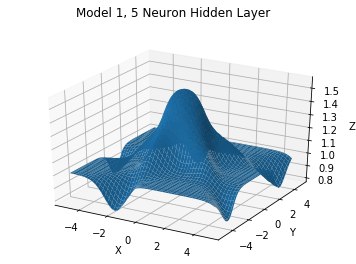

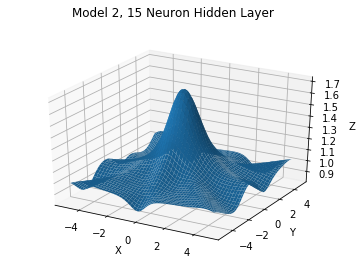

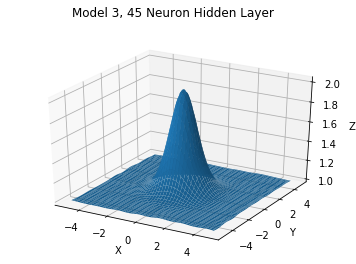

In [26]:
z = model1.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 1, 5 Neuron Hidden Layer")
z = model2.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 2, 15 Neuron Hidden Layer")
z = model3.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 3, 45 Neuron Hidden Layer")

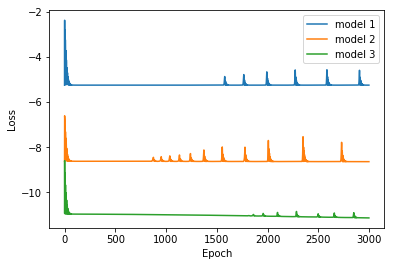

In [21]:
model1.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history1 = model1.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model2.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history2 = model2.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history3 = model3.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
model3.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history3 = model3.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)

lossPlot(np.log(history1.history['loss']),"model 1")
lossPlot(np.log(history2.history['loss']),"model 2")
lossPlot(np.log(history3.history['loss']),"model 3")
plt.show()

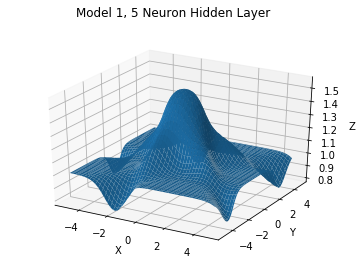

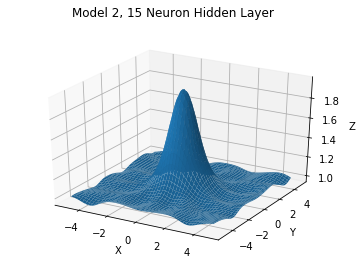

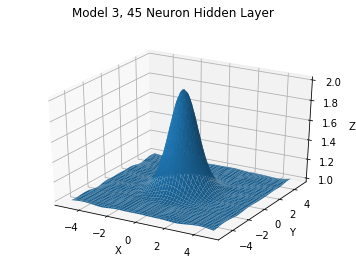

In [22]:
z = model1.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 1, 5 Neuron Hidden Layer")
z = model2.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 2, 15 Neuron Hidden Layer")
z = model3.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,"Model 3, 45 Neuron Hidden Layer")

In [28]:
layers = []
layers.append(keras.layers.Dense(4, input_dim = 2, activation="sigmoid"))
layers.append(keras.layers.Dense(3, input_dim = 2, activation="sigmoid"))

layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 4         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
None


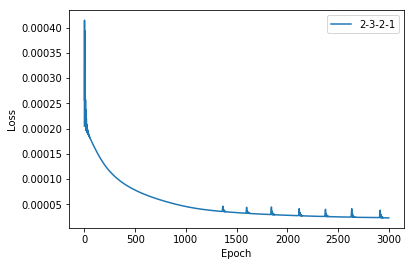

In [31]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=3000, verbose=0)
lossPlot(history.history['loss'],"2-3-2-1")
plt.show()

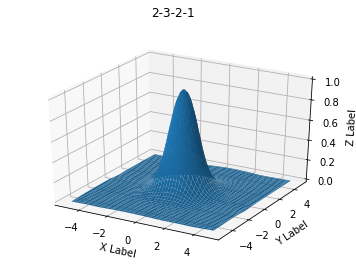

In [32]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100,'2-3-2-1')

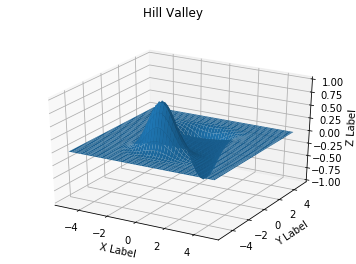

In [74]:
features, labels = generateGaussianHillValley(-5.0,5.0,-5.0,5.0,100,9)
plotGaussian(labels,-5.0,5.0,-5.0,5.0,100,200,"Hill Valley")

In [75]:
layers = []
layers.append(keras.layers.Dense(50, input_dim = 2, activation="tanh"))
layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
None


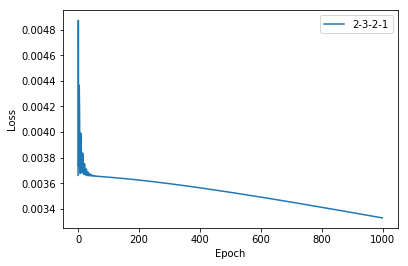

In [83]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)
lossPlot(history.history['loss'],"2-3-2-1")
plt.show()

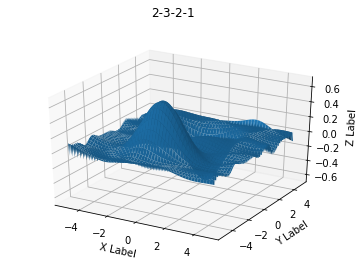

In [84]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,200,'2-3-2-1')

In [46]:
layers = []
layers.append(keras.layers.Dense(20, input_dim = 2, activation="tanh"))
layers.append(keras.layers.Dense(4, input_dim = 2, activation="tanh"))

layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 84        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________
None


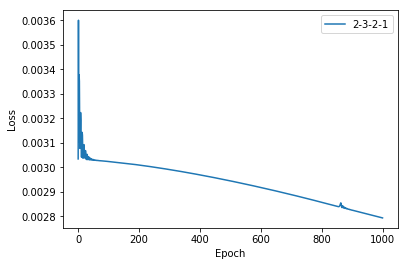

In [86]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)
lossPlot(history.history['loss'],"2-3-2-1")
plt.show()

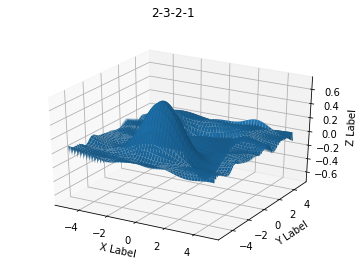

In [88]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,200,'2-3-2-1')

(300, 2)
(1200,)


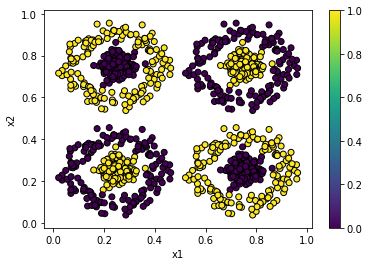

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


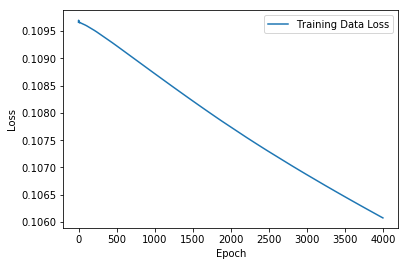

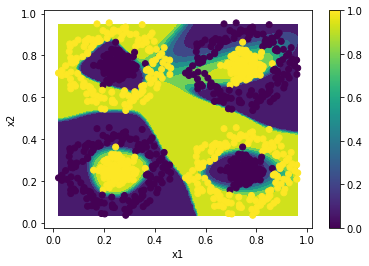

In [10]:
from sklearn.datasets import make_moons, make_circles

dataset_circle = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle1 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle2 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)
dataset_circle3 = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)

features_circle = dataset_circle[0]
labels_circle = dataset_circle[1]
labels_circle1 =labels_circle.copy()

features_circle[:,0] = (features_circle[:,0]+1.5)/6.0
features_circle[:,1] = (features_circle[:,1]+1.5)/6.0

features_circle2 = features_circle.copy()
features_circle2[:,0] = features_circle[:,0]+0.5

oneFilter = labels_circle ==1
zeroFilter = labels_circle ==0
labels_circle2 = labels_circle.copy()
labels_circle2[oneFilter] = 0
labels_circle2[zeroFilter] = 1


features_circle3 = features_circle.copy()
features_circle3[:,1] = features_circle[:,1]+0.5

features_circle4 = features_circle.copy()
features_circle4[:,1] = features_circle[:,1]+0.5
features_circle4[:,0] = features_circle[:,0]+0.5



print(features_circle.shape)
features_circle = np.append(features_circle,features_circle2, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle3, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle4, axis=0)
labels_circle = np.append(labels_circle,labels_circle1, axis=0)
print(labels_circle.shape)

x1_min = np.amin(features_circle[:,0])
x1_max = np.amax(features_circle[:,0])
x2_min = np.amin(features_circle[:,1])
x2_max = np.amax(features_circle[:,1])

plt.scatter(features_circle[:,0],features_circle[:,1],edgecolor="black",linewidth=1,c=labels_circle)
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()


layers = []
layers.append(keras.layers.Dense(10, input_dim = 2, activation="sigmoid"))

layers.append(keras.layers.Dense(1, activation="sigmoid"))

model = keras.Sequential(layers)
print(model.summary())
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=18000, verbose=0)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=4000, verbose=0)

loss = history.history['loss']
epoch = np.arange(0, len(loss))

plt.plot(epoch,loss, label='Training Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
xx, yy = np.meshgrid(np.arange(x1_min,x1_max,0.01),np.arange(x2_min,x2_max,0.01))

z = model.predict(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)

plt.contourf(xx,yy,z)
plt.scatter(features_circle[:,0],features_circle[:,1],c= labels_circle)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()